In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# import du dataframe pour diabete après retraitement du précédent sprint:
lien = "df_cancer_clean.csv"
df_cancer_breast = pd.read_csv(lien )
df_cancer_breast.head(5)

,Unnamed: 0,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# La colonnes "Unnamed: 0" doit être supprimée, car elle est inutile.

df_cancer_breast.drop(['Unnamed: 0','id'], axis=1, inplace = True)

In [ ]:
df_cancer_breast.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [ ]:
df_cancer_breast.shape

(556, 31)

## **Les groupes de variables**

**Les variables de type SE**
Les variables de type SE (erreur standard) dans le dataset du cancer du sein peuvent fournir des informations supplémentaires pour la prédiction, mais leur utilité dépend de la manière dont elles contribuent à la performance globale du modèle.

Pour déterminer si ces variables sont utiles, il est crucial de les inclure dans une analyse comparative avec d'autres types de variables (mean, worst) et d'évaluer leur impact sur la performance du modèle.

In [ ]:
# On crée les groupes de variables: 1) _mean 2) _mean_se 3) _mean_se_worst :

variables_mean = ['radius_mean', 'perimeter_mean','area_mean', 'texture_mean','smoothness_mean', 'compactness_mean',
                  'concavity_mean','concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']

variables_se = ['radius_se','perimeter_se', 'area_se', 'texture_se', 'smoothness_se',
               'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
               'fractal_dimension_se']

variables_worst = ['radius_worst','perimeter_worst', 'area_worst', 'texture_worst','smoothness_worst','compactness_worst', 'concavity_worst',
        'concave points_worst','symmetry_worst', 'fractal_dimension_worst']

variables_mean_se = variables_mean + variables_se

variables_mean_se_worst = variables_mean_se + variables_worst

## **ETAPE 1 . Gestion des valeurs aberrantes:**
**Outliers :**
Méthode pour les identifier : Sont valeurs aberrantes toutes les valeurs :
 - inférieures à : Q1 - (1.5*(Q3-Q1)
 - supérieures à : Q3 + (1.5*(Q3-Q1)

Ou Q1 = quartile 1, Q3 = quartile 3

### Pour info si on veut voir les outliers:

In [ ]:
# On selectionne les variables concernées:
variables = variables_mean_se_worst

# outliers_dict = {}
# outliers_dict_recap = {}

# for variable in variables:

       # Q1 = df_cancer_breast[variable].quantile(0.25)
       # Q3 = df_cancer_breast[variable].quantile(0.75)
       # IQR = Q3 - Q1

       # limite_inf= Q1 - 1.5 * IQR
       # limite_sup = Q3 + 1.5 * IQR

       # outliers = df_cancer_breast[(df_cancer_breast[variable] < limite_inf) | (df_cancer_breast[variable] > limite_sup)][variable]
       # outliers_dict[variable] = list(outliers)
       # outliers_dict_recap[variable] = len(outliers)

# outliers_dict_recap

In [ ]:
# On affiche les outliers pour infos:
# print(outliers_dict)

# Calcul du nombre total des outliers
# total_outliers = sum(len(outliers) for outliers in outliers_dict.values())
# print("nombre total des outliers :", total_outliers)


### Préparation des DF pour 4 scénarios:

Scenario 1.1 : Non correction des valeurs aberrantes<br>
Scénario 1.2 : On supprime les lignes contenant les valeurs aberrantes<br>
Scénario 1.3 : On remplace les valeurs aberrantes par la moyenne<br>
Scénario 1.4 : On remplace les valeurs aberrantes par la médiane<br>

In [ ]:
# déclaration des DF pour chaque scénario (le premier scénario restera le df_cancer_breast car aucun changement)
df_cancer_s1 = df_cancer_breast.copy()
df_cancer_s2_whithout_outliers = df_cancer_breast.copy()
df_cancer_s3_mean_outliers = df_cancer_breast.copy()
df_cancer_s4_median_outliers = df_cancer_breast.copy()

# On selectionne les variables concernées:
variables = variables_mean_se_worst

# identification des lignes avec écart interquartille
for colonne in variables:
  ecart_interQ =  df_cancer_breast[colonne].quantile(0.75) - df_cancer_breast[colonne].quantile(0.25)
  # print(colonne, " : ", ecart_interQ)
  # print("moyenne ", colonne, df_diabete[colonne].mean())
  # print("mediane ", colonne, df_diabete[colonne].median())
  condition = (df_cancer_breast[colonne] < df_cancer_breast[colonne].quantile(0.25) - ecart_interQ*1.5) | (df_cancer_breast[colonne] > df_cancer_breast[colonne].quantile(0.75) + ecart_interQ*1.5)

# préparation du DF pour le scénario 2
  df_cancer_s2_whithout_outliers = df_cancer_s2_whithout_outliers[~condition]

# préparation du DF pour le scénario 3
  df_cancer_s3_mean_outliers.loc[condition,colonne] = df_cancer_s3_mean_outliers[colonne].mean()

# préparation du DF pour le scénario 4
  df_cancer_s4_median_outliers.loc[condition,colonne] = df_cancer_s4_median_outliers[colonne].median()

# affichage des Df créés
display(df_cancer_s2_whithout_outliers)
display(df_cancer_s3_mean_outliers)
display(df_cancer_s4_median_outliers)

<ipython-input-82-8b5672f9160d>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cancer_s2_whithout_outliers = df_cancer_s2_whithout_outliers[~condition]
<ipython-input-82-8b5672f9160d>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cancer_s2_whithout_outliers = df_cancer_s2_whithout_outliers[~condition]
<ipython-input-82-8b5672f9160d>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cancer_s2_whithout_outliers = df_cancer_s2_whithout_outliers[~condition]
<ipython-input-82-8b5672f9160d>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cancer_s2_whithout_outliers = df_cancer_s2_whithout_outliers[~condition]
<ipython-input-82-8b5672f9160d>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cancer_s2_whithout_outliers = df_cancer_s2_whithout_outliers[~condition]
<ipython-input-82-8b5672f9160d>:19: UserWarning: B

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902
6,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368
7,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510
10,M,16.02,23.24,102.70,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,...,19.19,33.88,123.80,1150.0,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452
11,M,15.78,17.89,103.60,781.0,0.09710,0.12920,0.09954,0.06606,0.1842,...,20.42,27.28,136.50,1299.0,0.1396,0.5609,0.3965,0.18100,0.3792,0.10480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,B,12.88,28.92,82.50,514.3,0.08123,0.05824,0.06195,0.02343,0.1566,...,13.89,35.74,88.84,595.7,0.1227,0.1620,0.2439,0.06493,0.2372,0.07242
545,B,10.29,27.61,65.67,321.4,0.09030,0.07658,0.05999,0.02738,0.1593,...,10.84,34.91,69.57,357.6,0.1384,0.1710,0.2000,0.09127,0.2226,0.08283
547,B,14.59,22.68,96.39,657.1,0.08473,0.13300,0.10290,0.03736,0.1454,...,15.48,27.27,105.90,733.5,0.1026,0.3171,0.3662,0.11050,0.2258,0.08004
549,B,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,...,15.30,33.17,100.20,706.7,0.1241,0.2264,0.1326,0.10480,0.2250,0.08321


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.000000,0.118400,0.105679,0.090876,0.14710,0.241900,...,25.38,17.33,184.60,893.41241,0.162200,0.258472,0.711900,0.2654,0.290802,0.118900
1,M,20.57,17.77,132.90,1326.000000,0.084740,0.078640,0.086900,0.07017,0.181200,...,24.99,23.41,158.80,1956.00000,0.123800,0.186600,0.241600,0.1860,0.275000,0.089020
2,M,19.69,21.25,130.00,1203.000000,0.109600,0.159900,0.197400,0.12790,0.206900,...,23.57,25.53,152.50,1709.00000,0.144400,0.424500,0.450400,0.2430,0.361300,0.087580
3,M,11.42,20.38,77.58,386.100000,0.096616,0.105679,0.241400,0.10520,0.181278,...,14.91,26.50,98.87,567.70000,0.132824,0.258472,0.686900,0.2575,0.290802,0.084141
4,M,20.29,14.34,135.10,1297.000000,0.100300,0.132800,0.198000,0.10430,0.180900,...,22.54,16.67,152.20,1575.00000,0.137400,0.205000,0.400000,0.1625,0.236400,0.076780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,M,20.92,25.09,143.00,1347.000000,0.109900,0.223600,0.090876,0.14740,0.214900,...,24.29,29.41,179.10,1819.00000,0.140700,0.418600,0.659900,0.2542,0.292900,0.098730
552,M,21.56,22.39,142.00,663.734712,0.111000,0.115900,0.243900,0.13890,0.172600,...,25.45,26.40,166.10,893.41241,0.141000,0.211300,0.410700,0.2216,0.206000,0.071150
553,M,20.13,28.25,131.20,1261.000000,0.097800,0.103400,0.144000,0.09791,0.175200,...,23.69,38.25,155.00,1731.00000,0.116600,0.192200,0.321500,0.1628,0.257200,0.066370
554,M,16.60,28.08,108.30,858.100000,0.084550,0.102300,0.092510,0.05302,0.159000,...,18.98,34.12,126.70,1124.00000,0.113900,0.309400,0.340300,0.1418,0.221800,0.078200


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.00,0.118400,0.09509,0.064905,0.14710,0.24190,...,25.38,17.33,184.60,696.05,0.16220,0.2170,0.7119,0.2654,0.28245,0.118900
1,M,20.57,17.77,132.90,1326.00,0.084740,0.07864,0.086900,0.07017,0.18120,...,24.99,23.41,158.80,1956.00,0.12380,0.1866,0.2416,0.1860,0.27500,0.089020
2,M,19.69,21.25,130.00,1203.00,0.109600,0.15990,0.197400,0.12790,0.20690,...,23.57,25.53,152.50,1709.00,0.14440,0.4245,0.4504,0.2430,0.36130,0.087580
3,M,11.42,20.38,77.58,386.10,0.096035,0.09509,0.241400,0.10520,0.17925,...,14.91,26.50,98.87,567.70,0.13155,0.2170,0.6869,0.2575,0.28245,0.080075
4,M,20.29,14.34,135.10,1297.00,0.100300,0.13280,0.198000,0.10430,0.18090,...,22.54,16.67,152.20,1575.00,0.13740,0.2050,0.4000,0.1625,0.23640,0.076780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,M,20.92,25.09,143.00,1347.00,0.109900,0.22360,0.064905,0.14740,0.21490,...,24.29,29.41,179.10,1819.00,0.14070,0.4186,0.6599,0.2542,0.29290,0.098730
552,M,21.56,22.39,142.00,557.65,0.111000,0.11590,0.243900,0.13890,0.17260,...,25.45,26.40,166.10,696.05,0.14100,0.2113,0.4107,0.2216,0.20600,0.071150
553,M,20.13,28.25,131.20,1261.00,0.097800,0.10340,0.144000,0.09791,0.17520,...,23.69,38.25,155.00,1731.00,0.11660,0.1922,0.3215,0.1628,0.25720,0.066370
554,M,16.60,28.08,108.30,858.10,0.084550,0.10230,0.092510,0.05302,0.15900,...,18.98,34.12,126.70,1124.00,0.11390,0.3094,0.3403,0.1418,0.22180,0.078200


In [ ]:
# On crée un dictionnaire avec nos 4DF
liste_df = {"df_cancer_s1" : df_cancer_s1,
            "df_cancer_s2" : df_cancer_s2_whithout_outliers,
            "df_cancer_s3" : df_cancer_s3_mean_outliers,
            "df_cancer_s4" : df_cancer_s4_median_outliers}

## Préparation des 4 Algos à étudier:

In [ ]:
# déclaration des différentes variables pour chaque algorithme de régression

algo_RL = LogisticRegression(random_state=32)
algo_KNN = KNeighborsClassifier()
algo_DTC = DecisionTreeClassifier(random_state=32)
algo_RFC = RandomForestClassifier(random_state=32)

# déclaration de la liste des algorithmes
liste_algo = [algo_RL, algo_KNN, algo_DTC, algo_RFC]

## Test pour avec 4 scénarios (4DF) avec 4 algo:
 Pour rappel :

Scenario 1.1 : Non correction des valeurs aberrantes<br>
Scénario 1.2 : On supprime les lignes contenant les valeurs aberrantes<br>
Scénario 1.3 : On remplace les valeurs aberrantes par la moyenne<br>
Scénario 1.4 : On remplace les valeurs aberrantes par la médiane<br>

4 alogo à tester pour chaque scénario:

algo_RL = LogisticRegression()<br>
algo_KNN = KNeighborsClassifier()<br>
algo_DTC = DecisionTreeClassifier()<br>
algo_RFC = RandomForestClassifier()<br>


In [ ]:
# On teste nos 4 algos avec chaque DF:
# une boucle pour utiliser les diff df:
for name, df in liste_df.items():

  # Définition de variables Exp et y
    var_exp = variables_mean_se_worst
    var_y = 'diagnosis'

  # Déclaration de la variable explicative et de la variable expliquées
    X = df[var_exp]
    y = df[var_y]

  #split du df entre jeu d'entrainement et jeu de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=32)

    for algo in liste_algo:
    # Entraîner le modèle avec les données non standardisées:
        algo.fit(X_train, y_train)
        print("\n",name, " : ")
        print(algo," : ","Train score :", round(algo.score(X_train, y_train),2),"Test score :", round(algo.score(X_test, y_test),2), "\n")

    # Calcul de la matrice de confusion avec les données de test

        matrice_confusion = pd.DataFrame(
                                        data = confusion_matrix(y_true = y_test, y_pred = algo.predict(X_test)),
                                        index = algo.classes_ + " ACTUAL",
                                        columns = algo.classes_ + " PREDICTED")

        display(matrice_confusion)


 df_cancer_s1  : 
LogisticRegression(random_state=32)  :  Train score : 0.96 Test score : 0.94 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,B PREDICTED,M PREDICTED
B ACTUAL,86,3
M ACTUAL,6,44



 df_cancer_s1  : 
KNeighborsClassifier()  :  Train score : 0.94 Test score : 0.92 



,B PREDICTED,M PREDICTED
B ACTUAL,87,2
M ACTUAL,9,41



 df_cancer_s1  : 
DecisionTreeClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.92 



,B PREDICTED,M PREDICTED
B ACTUAL,83,6
M ACTUAL,5,45



 df_cancer_s1  : 
RandomForestClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.96 



,B PREDICTED,M PREDICTED
B ACTUAL,88,1
M ACTUAL,4,46



 df_cancer_s2  : 
LogisticRegression(random_state=32)  :  Train score : 0.95 Test score : 0.93 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,B PREDICTED,M PREDICTED
B ACTUAL,73,4
M ACTUAL,3,19



 df_cancer_s2  : 
KNeighborsClassifier()  :  Train score : 0.94 Test score : 0.95 



,B PREDICTED,M PREDICTED
B ACTUAL,74,3
M ACTUAL,2,20



 df_cancer_s2  : 
DecisionTreeClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.85 



,B PREDICTED,M PREDICTED
B ACTUAL,69,8
M ACTUAL,7,15



 df_cancer_s2  : 
RandomForestClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.93 



,B PREDICTED,M PREDICTED
B ACTUAL,73,4
M ACTUAL,3,19



 df_cancer_s3  : 
LogisticRegression(random_state=32)  :  Train score : 0.91 Test score : 0.94 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,B PREDICTED,M PREDICTED
B ACTUAL,84,5
M ACTUAL,4,46



 df_cancer_s3  : 
KNeighborsClassifier()  :  Train score : 0.94 Test score : 0.91 



,B PREDICTED,M PREDICTED
B ACTUAL,86,3
M ACTUAL,9,41



 df_cancer_s3  : 
DecisionTreeClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.88 



,B PREDICTED,M PREDICTED
B ACTUAL,77,12
M ACTUAL,5,45



 df_cancer_s3  : 
RandomForestClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.97 



,B PREDICTED,M PREDICTED
B ACTUAL,87,2
M ACTUAL,2,48



 df_cancer_s4  : 
LogisticRegression(random_state=32)  :  Train score : 0.89 Test score : 0.91 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,B PREDICTED,M PREDICTED
B ACTUAL,83,6
M ACTUAL,7,43



 df_cancer_s4  : 
KNeighborsClassifier()  :  Train score : 0.93 Test score : 0.91 



,B PREDICTED,M PREDICTED
B ACTUAL,86,3
M ACTUAL,9,41



 df_cancer_s4  : 
DecisionTreeClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.89 



,B PREDICTED,M PREDICTED
B ACTUAL,78,11
M ACTUAL,4,46



 df_cancer_s4  : 
RandomForestClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.96 



,B PREDICTED,M PREDICTED
B ACTUAL,85,4
M ACTUAL,1,49


### **Conclusion ETAPE 1.**

=> on retient l'option du Scénarios 1.3 pour la suite: on remplace les valeurs aberrantes par la **Mediane**

## **ETAPE 2. Gestion des variables significatives :**

Méthode pour les repérer : On se base sur le résultat du test Kruskal-Wallis.
On va tester deux niveaux de significativité :
- p-value = 0.05
- p-value = 0.01

Scenario 2.1 : Test de l'ensemble des variables<br>
Scénario 2.2 : On enlève les variables non significatives pour une p-value > 0.05<br>
Scénario 2.3 : On enlève les variables non-significatives pour une p-value > 0.01<br>


In [ ]:
df_cancer_s2_all = df_cancer_s4_median_outliers.copy()

In [ ]:
# Split de mon df_diabete entre la valeur outcome = 0 et outcome = 1
df_cancer_0 = df_cancer_s2_all[df_cancer_s2_all['diagnosis']== "B"]
df_cancer_1 = df_cancer_s2_all[df_cancer_s2_all['diagnosis']== "M"]

In [ ]:
# partie MannWithneyU

columns = variables_mean_se_worst

Mann_statistics = []
p_values_Mann = []
significant_Mann_05 = []
significant_Mann_01 = []

for colonne in columns:
  stat, result = mannwhitneyu(df_cancer_0[colonne], df_cancer_1[colonne])
  Mann_statistics.append(stat)
  p_values_Mann.append(result)
  significant_Mann_05.append(result < 0.05)
  significant_Mann_01.append(result < 0.01)

results_Mann = pd.DataFrame({
    'Variable': columns,                                                         # Le nom de la variable analysée.
    'P-Value_Mann': p_values_Mann,                                                 # Indicateur de significativité (True si p < 0.05, False sinon).
    'Significant (p < 0.05)': significant_Mann_05,
    'Significant (p < 0.01)': significant_Mann_01,
})

results_Mann

,Variable,P-Value_Mann,Significant (p < 0.05),Significant (p < 0.01)
0,radius_mean,1.500904e-62,True,True
1,perimeter_mean,3.121543e-65,True,True
2,area_mean,2.802648e-59,True,True
3,texture_mean,1.047398e-28,True,True
4,smoothness_mean,5.820382e-18,True,True
5,compactness_mean,2.706429e-40,True,True
6,concavity_mean,2.697424e-64,True,True
7,concave points_mean,6.648922e-72,True,True
8,symmetry_mean,1.356247e-14,True,True
9,fractal_dimension_mean,6.965511e-01,False,False


In [ ]:
# ressortir les variable donc le p value est inférieur à 0.05 et 0.01 sous forme de liste pour préparer les futur modèle de Machine Learning
liste_variable_p_05 = list(results_Mann['Variable'][results_Mann['Significant (p < 0.05)'] == True])
liste_variable_p_01 = list(results_Mann['Variable'][results_Mann['Significant (p < 0.01)'] == True])

# afficher le nb de variables par liste:
display(len(liste_variable_p_05))
display(len(liste_variable_p_01))

27

27

In [ ]:
# On teste des différents algorithmsrythmes avec les nouvelles listes de variables :

# déclaration de  distionnaire de variables:
dict_variable  = (liste_variable_p_05, liste_variable_p_01)

for variable in dict_variable:

  # Définition de variables Exp et y
  var_exp = variable
  var_y = 'diagnosis'

  # Déclaration de la variable explicative et de la variable expliquées
  X = df_cancer_s2_all[var_exp]
  y = df_cancer_s2_all[var_y]

  #split du df entre jeu d'entrainement et jeu de test
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=32)

  for algo in liste_algo:

    # Entraîner le modèle avec les données non standardisées:
    algo.fit(X_train, y_train)

    print(algo," : ","Train score :", round(algo.score(X_train, y_train),2),"Test score :", round(algo.score(X_test, y_test),2), "\n")

    # Calcul de la matrice de confusion avec les données de test
    matrice_confusion = pd.DataFrame(
        data = confusion_matrix(y_true = y_test, y_pred = algo.predict(X_test)),
        index = algo.classes_ + " ACTUAL",
        columns = algo.classes_ + " PREDICTED")

    display(matrice_confusion)

LogisticRegression(random_state=32)  :  Train score : 0.89 Test score : 0.91 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,B PREDICTED,M PREDICTED
B ACTUAL,83,6
M ACTUAL,6,44


KNeighborsClassifier()  :  Train score : 0.93 Test score : 0.91 



,B PREDICTED,M PREDICTED
B ACTUAL,86,3
M ACTUAL,9,41


DecisionTreeClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.92 



,B PREDICTED,M PREDICTED
B ACTUAL,82,7
M ACTUAL,4,46


RandomForestClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.94 



,B PREDICTED,M PREDICTED
B ACTUAL,84,5
M ACTUAL,3,47


LogisticRegression(random_state=32)  :  Train score : 0.89 Test score : 0.91 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,B PREDICTED,M PREDICTED
B ACTUAL,83,6
M ACTUAL,6,44


KNeighborsClassifier()  :  Train score : 0.93 Test score : 0.91 



,B PREDICTED,M PREDICTED
B ACTUAL,86,3
M ACTUAL,9,41


DecisionTreeClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.92 



,B PREDICTED,M PREDICTED
B ACTUAL,82,7
M ACTUAL,4,46


RandomForestClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.94 



,B PREDICTED,M PREDICTED
B ACTUAL,84,5
M ACTUAL,3,47


### **Conclusion ETAPE 2:**

=> les tests réalisés sont ne permettent pas de prendre la décision s'il faut ou pas enlever les variables significatives. On va tester avec les variables dépendentes<br>
 Pour voir plus calire on vérifie aussi la correlation entre les variables

## **ETAPE 3. Gestion des variables dépendantes :**

Méthode pour les repérer : taux de corrélation > 0.80<br>
Scénario 3.1 : Test de l'ensemble des variables<br>
Scénario 3.2 : On enlève une des variables dépendantes<br>
Scénario 3.3 : On enlève une autre variable dépendante<br>
On fait autant de scénarii qu'il y a de combinaisons possibles entre ces variables dépendantes<br>


In [ ]:
df_cancer_s3_all = df_cancer_s2_all.copy()

In [ ]:
# HEATMAP: On fait le graph Heatmap visualiser les matrices de corrélation entre plusieurs variables
# Exclure les colonnes non numériques
numerical_columns = df_cancer_s3_all.select_dtypes(include=['int', 'float']).columns


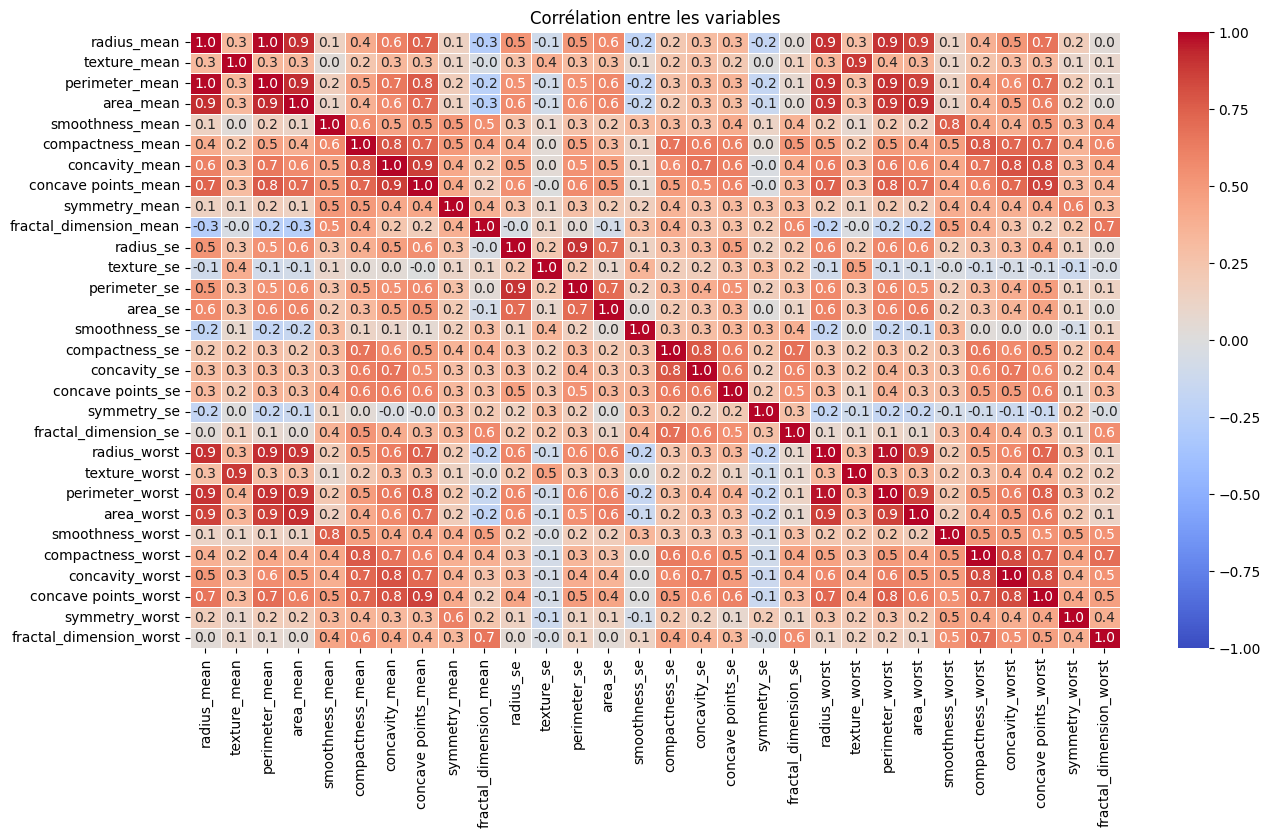

In [ ]:
# Calculer la matrice de corrélation
corr_matrix = df_cancer_s3_all[numerical_columns].corr()

# création du heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5, center =0, vmin=-1, vmax=1)
plt.title('Corrélation entre les variables')
plt.show()



<Axes: >

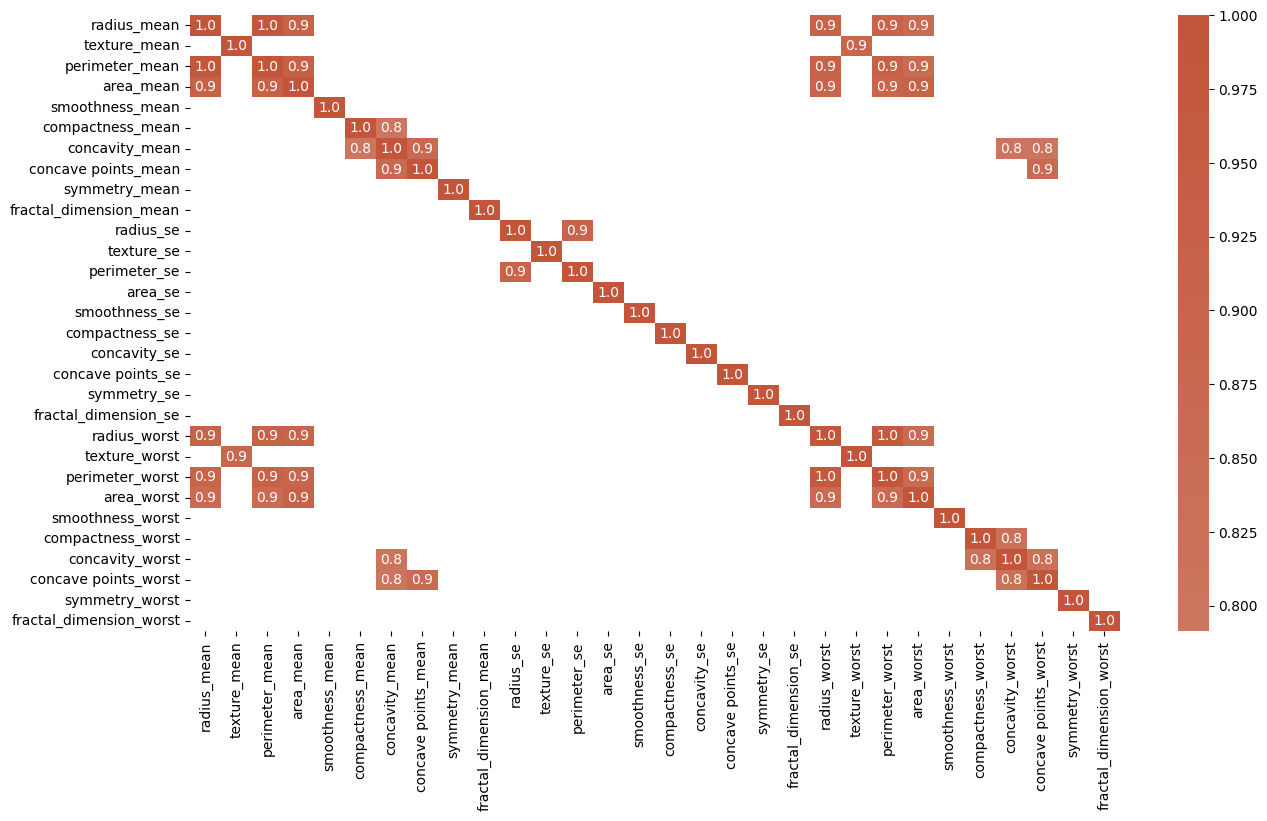

In [ ]:
# Le paramètre Mask permet d'identifier les variable qui indique une corrélation élevée
# cmap me permet de paramètrer la couleur pour mettre en évidence les nombres=> à 0,80
plt.figure(figsize=(15, 8))
sns.heatmap(data = df_cancer_s3_all[numerical_columns].corr(), mask = np.abs(df_cancer_s3_all[numerical_columns].corr()) <= 0.79,
            cmap = sns.diverging_palette(220, 20, as_cmap=True), center = 0, annot = True, fmt=".1f")

In [ ]:
# Scenario 3.1 : DF de l'ensemble des variables
df_cancer_s3_all

# Scenario 3.2 : on enlève les variables très fortement corréllées :
#  "perimeter (mean, se, worst)"
#  "area (mean et worst)",
#  'radius_worst', 'texture_worst'
#  "concavity (mean et worts), 'concave points_mean'
variables_without_features_corr = ['radius_mean', 'texture_mean','smoothness_mean', 'compactness_mean',
                                    'symmetry_mean', 'fractal_dimension_mean','radius_se', 'texture_se',
                                    'area_se','smoothness_se','compactness_se','concavity_se','concave points_se', 'symmetry_se',
                                    'fractal_dimension_se','smoothness_worst','compactness_worst',
                                    'concave points_worst','symmetry_worst', 'fractal_dimension_worst']

# Scenario 3.2 : on enlève les variables non significatives : fractal_dimension_mean, texture_se et smoothness_se
variables_without_non_signif = ['radius_mean', 'texture_mean','smoothness_mean', 'compactness_mean',
                                    'symmetry_mean','radius_se','area_se','compactness_se', 'concavity_se',
                                     'concave points_se', 'symmetry_se','fractal_dimension_se','smoothness_worst',
                                    'compactness_worst','concave points_worst','symmetry_worst', 'fractal_dimension_worst']

In [ ]:
print(len(variables_without_features_corr))
print(len(variables_without_non_signif))

20
17


<Axes: >

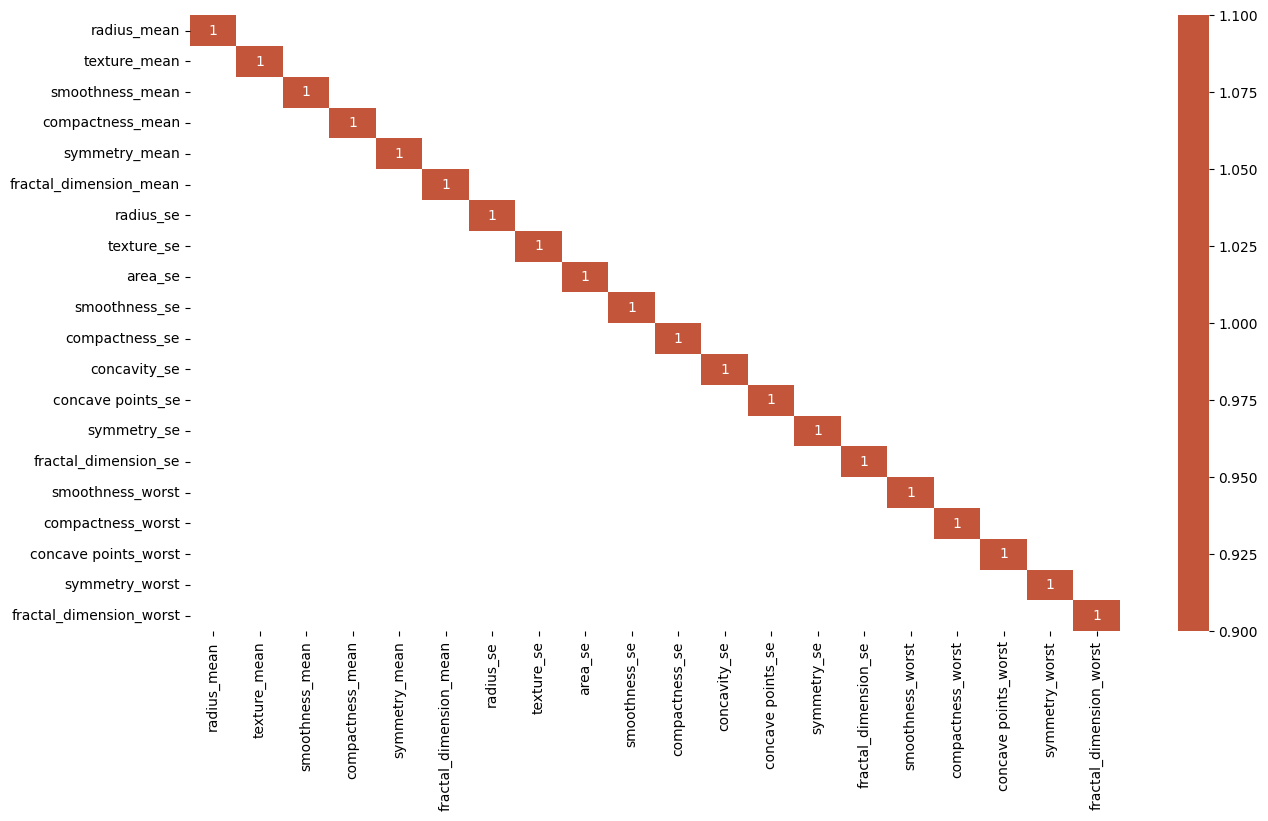

In [ ]:
# Le paramètre Mask permet d'identifier les variable qui indique une corrélation élevée
# cmap me permet de paramètrer la couleur pour mettre en évidence les nombres supérieur à 0,80
plt.figure(figsize=(15, 8))
sns.heatmap(data = df_cancer_s3_all[variables_without_features_corr].corr(), mask = np.abs(df_cancer_s3_all[variables_without_features_corr].corr()) < 0.79,
            cmap = sns.diverging_palette(220, 20, as_cmap=True), center = 0, annot = True)

In [ ]:
# déclaration de dictionnaire des variables:
dict_variables = {"df_cancer_all" : variables_mean_se_worst, "df_cancer_without_features_corr" : variables_without_features_corr, "df_cancer_without_non_signif" : variables_without_non_signif}

In [ ]:
# On applique 4 ML pour chaque scenario à l'aide des boucles:

for name, var_exp in dict_variables.items():
    # Définition de y:
    var_y = 'diagnosis'

    # Déclaration de la variable explicative et de la variable expliquées
    X = df_cancer_s3_all[var_exp]
    y = df_cancer_s3_all[var_y]

    #split du df entre jeu d'entrainement et jeu de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=32)


    for algo in liste_algo:
        # Entraîner le modèle avec les données non standardisées:
        algo.fit(X_train, y_train)
        print("\n DF",name," : ")
        print(algo," : ","Train score :", round(algo.score(X_train, y_train),2),"Test score :", round(algo.score(X_test, y_test),2), "\n")

        # Calcul de la matrice de confusion avec les données de test
        y_pred = algo.predict(X_test)
        matrice_confusion = pd.DataFrame(
            data = confusion_matrix(y_true = y_test, y_pred = y_pred),
            index = algo.classes_ + " ACTUAL",
            columns = algo.classes_ + " PREDICTED")

        display(matrice_confusion)


 DF df_cancer_all  : 
LogisticRegression(random_state=32)  :  Train score : 0.89 Test score : 0.91 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,B PREDICTED,M PREDICTED
B ACTUAL,83,6
M ACTUAL,7,43



 DF df_cancer_all  : 
KNeighborsClassifier()  :  Train score : 0.93 Test score : 0.91 



,B PREDICTED,M PREDICTED
B ACTUAL,86,3
M ACTUAL,9,41



 DF df_cancer_all  : 
DecisionTreeClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.89 



,B PREDICTED,M PREDICTED
B ACTUAL,78,11
M ACTUAL,4,46



 DF df_cancer_all  : 
RandomForestClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.96 



,B PREDICTED,M PREDICTED
B ACTUAL,85,4
M ACTUAL,1,49



 DF df_cancer_without_features_corr  : 
LogisticRegression(random_state=32)  :  Train score : 0.91 Test score : 0.88 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,B PREDICTED,M PREDICTED
B ACTUAL,81,8
M ACTUAL,8,42



 DF df_cancer_without_features_corr  : 
KNeighborsClassifier()  :  Train score : 0.91 Test score : 0.88 



,B PREDICTED,M PREDICTED
B ACTUAL,81,8
M ACTUAL,9,41



 DF df_cancer_without_features_corr  : 
DecisionTreeClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.91 



,B PREDICTED,M PREDICTED
B ACTUAL,82,7
M ACTUAL,5,45



 DF df_cancer_without_features_corr  : 
RandomForestClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.97 



,B PREDICTED,M PREDICTED
B ACTUAL,87,2
M ACTUAL,2,48



 DF df_cancer_without_non_signif  : 
LogisticRegression(random_state=32)  :  Train score : 0.92 Test score : 0.88 



,B PREDICTED,M PREDICTED
B ACTUAL,81,8
M ACTUAL,8,42



 DF df_cancer_without_non_signif  : 
KNeighborsClassifier()  :  Train score : 0.91 Test score : 0.89 



,B PREDICTED,M PREDICTED
B ACTUAL,83,6
M ACTUAL,9,41



 DF df_cancer_without_non_signif  : 
DecisionTreeClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.93 



,B PREDICTED,M PREDICTED
B ACTUAL,83,6
M ACTUAL,4,46



 DF df_cancer_without_non_signif  : 
RandomForestClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.97 



,B PREDICTED,M PREDICTED
B ACTUAL,87,2
M ACTUAL,2,48


'**Conclusion etape 3:** => on retient l'option du Scénarios 3.3 pour la suite: on a enlévé: <br>
1) les variables fortement correlées ("perimeter (mean, se, worst)"
 "area (mean et worst)", "radius_worst', 'texture_worst', "concavity (mean et worts), 'concave points_mean')<br>
 2) les variables non significatives MannWithneyU: fractal_dimension_mean, texture_se et smoothness_se<br>


In [ ]:
# Notre nouvelle DF:
df_cancer_s4 = df_cancer_s3_all[['diagnosis','radius_mean', 'texture_mean','smoothness_mean', 'compactness_mean',
                                    'symmetry_mean','radius_se','area_se','compactness_se', 'concavity_se',
                                     'concave points_se', 'symmetry_se','fractal_dimension_se','smoothness_worst',
                                    'compactness_worst','concave points_worst','symmetry_worst', 'fractal_dimension_worst']]
df_cancer_s4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                556 non-null    object 
 1   radius_mean              556 non-null    float64
 2   texture_mean             556 non-null    float64
 3   smoothness_mean          556 non-null    float64
 4   compactness_mean         556 non-null    float64
 5   symmetry_mean            556 non-null    float64
 6   radius_se                556 non-null    float64
 7   area_se                  556 non-null    float64
 8   compactness_se           556 non-null    float64
 9   concavity_se             556 non-null    float64
 10  concave points_se        556 non-null    float64
 11  symmetry_se              556 non-null    float64
 12  fractal_dimension_se     556 non-null    float64
 13  smoothness_worst         556 non-null    float64
 14  compactness_worst        5

## **ETAPE 6. standartisation avec Standart Scaler**

In [ ]:
# On applique 4 ML pour chaque scenario à l'aide des boucles:

# Définition de variables Exp et y
var_exp = df_cancer_s4.columns[1:]
var_y = 'diagnosis'

# Déclaration de la variable explicative et de la variable expliquées
X = df_cancer_s4[var_exp]
y = df_cancer_s4[var_y]

#split du df entre jeu d'entrainement et jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=32)

# Initialisation du Scaler
scaler = StandardScaler()

# Je déclarer mes variable X_train et X_test version scaled, pour permettre de normaliser mes données
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


for algo in liste_algo:
    # Entraîner le modèle avec les données non standardisées:
    algo.fit(X_train_scaled, y_train)
    print("\n DF",name," : ")
    print(algo," : ","Train score :", round(algo.score(X_train_scaled, y_train),2),"Test score :", round(algo.score(X_test_scaled, y_test),2), "\n")

    # Calcul de la matrice de confusion avec les données de test
    y_pred = algo.predict(X_test_scaled)
    matrice_confusion = pd.DataFrame(
        data = confusion_matrix(y_true = y_test, y_pred = y_pred),
        index = algo.classes_ + " ACTUAL",
        columns = algo.classes_ + " PREDICTED")

    display(matrice_confusion)


 DF df_cancer_without_non_signif  : 
LogisticRegression(random_state=32)  :  Train score : 0.97 Test score : 0.96 



,B PREDICTED,M PREDICTED
B ACTUAL,86,3
M ACTUAL,2,48



 DF df_cancer_without_non_signif  : 
KNeighborsClassifier()  :  Train score : 0.97 Test score : 0.96 



,B PREDICTED,M PREDICTED
B ACTUAL,86,3
M ACTUAL,2,48



 DF df_cancer_without_non_signif  : 
DecisionTreeClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.93 



,B PREDICTED,M PREDICTED
B ACTUAL,83,6
M ACTUAL,4,46



 DF df_cancer_without_non_signif  : 
RandomForestClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.96 



,B PREDICTED,M PREDICTED
B ACTUAL,87,2
M ACTUAL,3,47


## **ETAPE 5. Données déséquilibrées**
Scénario 5.1 : Test de l'ensemble sans standartisation <br>
Scénario 5.2 : Répartition dans le train set de l'ordre de 50/50 (technique SMOTE) <br>


In [ ]:
df_cancer_s4['diagnosis'].value_counts(normalize = True)

diagnosis
B    0.618705
M    0.381295
Name: proportion, dtype: float64

In [ ]:
# la proportion actielle est 62/38 => un léger désiquilibre constaté dans les classes : il faut au moins la proportion 60/40

### Pour traiter les données déséquilibrées j'utilise **la technique Oversampling (Suréchantillonnage)**. Cette technique consiste à augmenter le nombre d'échantillons dans la classe minoritaire pour équilibrer les proportions. La méthode la plus courante est le Synthetic Minority Over-sampling Technique (SMOTE).

In [ ]:
# pour rappel, notre liste des algos:
# algo_RL = LogisticRegression(random_state=32)
# algo_KNN = KNeighborsClassifier()
# algo_DTC = DecisionTreeClassifier(random_state=32)
# algo_RFC = RandomForestClassifier(random_state=32)

# la liste des algorithmes:
liste_algo = [algo_RL, algo_KNN, algo_DTC, algo_RFC]

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
# On réajiste les proportions des classes en utilisant la methode SMOTE:

# Définition de variables Exp et y
var_exp = df_cancer_s4.columns[1:]
var_y = 'diagnosis'

# Déclaration de la variable explicative et de la variable expliquées
X = df_cancer_s4[var_exp]
y = df_cancer_s4[var_y]

# Diviser les données en ensembles d'entraînement et de test avant l'oversampling :
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=32, stratify=y)

# Appliquer SMOTE sur l'ensemble d'entraînement
# Utilisation de sampling_strategy='auto' pour ajustement automatique du ratio en fonction de la distribution des classes dans l'ensemble d'entraînement
smote = SMOTE(sampling_strategy='auto', random_state=32)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Vérification des nouvelles proposrtions:
new_distribution = Counter(y_train_res)
total_samples = sum(new_distribution.values())
new_proportions = {class_label: count / total_samples for class_label, count in new_distribution.items()}
print("\nDistribution des classes après SMOTE:", new_distribution)
print("Proportions des classes après SMOTE:", new_proportions, "\n")


# Appliquer StandardScaler sur les données suréchantillonnées et les données de test :
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Entraîner mes 4 modèles avec les données suréchantillonnées et normalisées :

for algo in liste_algo:
    # Entraîner le modèle avec les données non standardisées:
    algo.fit(X_train_res_scaled, y_train_res)
    print(algo," : ","Train score :", round(algo.score(X_train_res_scaled, y_train_res),2),"Test score :", round(algo.score(X_test_scaled, y_test),2), "\n")

    # Calcul de la matrice de confusion avec les données de test
    y_pred = algo.predict(X_test_scaled)
    matrice_confusion = pd.DataFrame(
        data = confusion_matrix(y_true = y_test, y_pred = y_pred),
        index = algo.classes_ + " ACTUAL",
        columns = algo.classes_ + " PREDICTED")

    display(matrice_confusion)



Distribution des classes après SMOTE: Counter({'B': 258, 'M': 258})
Proportions des classes après SMOTE: {'B': 0.5, 'M': 0.5} 

LogisticRegression(random_state=32)  :  Train score : 0.96 Test score : 0.98 



,B PREDICTED,M PREDICTED
B ACTUAL,86,0
M ACTUAL,3,50


KNeighborsClassifier()  :  Train score : 0.95 Test score : 0.96 



,B PREDICTED,M PREDICTED
B ACTUAL,84,2
M ACTUAL,3,50


DecisionTreeClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.88 



,B PREDICTED,M PREDICTED
B ACTUAL,78,8
M ACTUAL,8,45


RandomForestClassifier(random_state=32)  :  Train score : 1.0 Test score : 0.94 



,B PREDICTED,M PREDICTED
B ACTUAL,82,4
M ACTUAL,4,49


## **ETAPE 6. Optimisation des hyperparamètres :** Utilisation de GridSearchCV pour trouver les meilleurs hyperparamètres pour chaque algorithme.


In [ ]:
# On importe la bibliotheque  GridSearchCV:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Définition de variables Exp et y
var_exp = df_cancer_s4.columns[1:]
var_y = 'diagnosis'

# Déclaration de la variable explicative et de la variable expliquées
X = df_cancer_s4[var_exp]
y = df_cancer_s4[var_y]

# Diviser les données en ensembles d'entraînement et de test avant l'oversampling :
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=32, stratify=y)

# Appliquer SMOTE sur l'ensemble d'entraînement
# Utilisation de sampling_strategy='auto' pour ajustement automatique du ratio en fonction de la distribution des classes dans l'ensemble d'entraînement
smote = SMOTE(sampling_strategy='auto', random_state=32)
X_train_res, y_train_res = smote.fit_resample(X, y)

# Vérifier la nouvelle distribution des classes après SMOTE
print("\nDistribution des classes après SMOTE:", Counter(y_train_res),"\n")

# Appliquer StandardScaler sur les données suréchantillonnées et les données de test :
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


# Définir une liste d'algorithmes et leurs grilles de paramètres pour l'optimisation
liste_algo = [
    (LogisticRegression(random_state=32), {'C':  [1, 10], 'solver': ['liblinear', 'lbfgs']}),
    (KNeighborsClassifier(), {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']}),
    (DecisionTreeClassifier(random_state=32), {'max_depth': [20, 30], 'min_samples_split': [2, 5,10], 'min_samples_leaf': [1, 2, 4]}),
    (RandomForestClassifier(random_state=32), {'n_estimators': [200, 300], 'max_depth': [20,30]}),
    (SVC(random_state=32), {'C':  [10, 100], 'kernel': ['linear', 'poly'], 'gamma': ['scale', 'auto'],
    'degree': [4]})
]

# Entraîner mes 4 modèles avec les données suréchantillonnées et normalisées :

# Entraîner et évaluer chaque modèle
for algo, params in liste_algo:
    algo_name = algo.__class__.__name__
    grid_search = GridSearchCV(estimator=algo, param_grid=params, cv=5, scoring='accuracy')
    grid_search.fit(X_train_res_scaled, y_train_res)
    best_model = grid_search.best_estimator_

    # Évaluation du modèle
    y_pred = best_model.predict(X_test_scaled)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nModèle {algo_name} :")
    print("Meilleurs hyperparamètres:", grid_search.best_params_,"\n")
    print(f"Train score : {round(best_model.score(X_train_res_scaled, y_train_res), 2)}")
    print(f"Test score : {round(best_model.score(X_test_scaled, y_test), 2)}\n")
    print(f"Accuracy : {round(accuracy, 2)}\n")


 # Calcul de la matrice de confusion avec les données de test
    matrice_confusion = pd.DataFrame(
        data=confusion_matrix(y_true=y_test, y_pred=y_pred),
        index = best_model.classes_ + " ACTUAL",
        columns = best_model.classes_ + " PREDICTED")

    display(matrice_confusion)




Distribution des classes après SMOTE: Counter({'M': 344, 'B': 344}) 


Modèle LogisticRegression :
Meilleurs hyperparamètres: {'C': 10, 'solver': 'liblinear'} 

Train score : 0.97
Test score : 0.98

Accuracy : 0.98



,B PREDICTED,M PREDICTED
B ACTUAL,86,0
M ACTUAL,3,50



Modèle KNeighborsClassifier :
Meilleurs hyperparamètres: {'n_neighbors': 5, 'weights': 'distance'} 

Train score : 1.0
Test score : 1.0

Accuracy : 1.0



,B PREDICTED,M PREDICTED
B ACTUAL,86,0
M ACTUAL,0,53



Modèle DecisionTreeClassifier :
Meilleurs hyperparamètres: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10} 

Train score : 0.98
Test score : 0.99

Accuracy : 0.99



,B PREDICTED,M PREDICTED
B ACTUAL,85,1
M ACTUAL,1,52



Modèle RandomForestClassifier :
Meilleurs hyperparamètres: {'max_depth': 20, 'n_estimators': 300} 

Train score : 1.0
Test score : 1.0

Accuracy : 1.0



,B PREDICTED,M PREDICTED
B ACTUAL,86,0
M ACTUAL,0,53



Modèle SVC :
Meilleurs hyperparamètres: {'C': 10, 'degree': 4, 'gamma': 'scale', 'kernel': 'linear'} 

Train score : 0.97
Test score : 0.98

Accuracy : 0.98



,B PREDICTED,M PREDICTED
B ACTUAL,86,0
M ACTUAL,3,50


## **ETAPE 7. Test des différents scalers et nouveaux Algorythmes**<br>
 * le test des différents scaler:  Normalizer(), StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler(),PowerTransformer()<br>
 * le test des nouveaux algos : XGBClassifier(), LGBMClassifier(), Support Vector Classifier :SVC()

In [ ]:
# On importe les bibliotheques:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, PowerTransformer
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [ ]:
# Définition de variables Exp et y
var_exp = df_cancer_s4.columns[1:]
var_y = 'diagnosis'

# Déclaration de la variable explicative et de la variable expliquées
X = df_cancer_s4[var_exp]
y = df_cancer_s4[var_y]

# Diviser les données en ensembles d'entraînement et de test avant l'oversampling :
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=32, stratify=y)

# Appliquer SMOTE sur l'ensemble d'entraînement
# Utilisation de sampling_strategy='auto' pour ajustement automatique du ratio en fonction de la distribution des classes dans l'ensemble d'entraînement
smote = SMOTE(sampling_strategy='auto', random_state=32)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Définir les scalers
scalers = {
    'Normalizer': Normalizer(),
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'MaxAbsScaler': MaxAbsScaler(),
    'RobustScaler': RobustScaler(),
    'PowerTransformer': PowerTransformer()
}
# Définir les modèles
models = {
    'Logistic Regression': LogisticRegression(random_state=32, C=1, solver='liblinear'),
    'Random Forest': RandomForestClassifier(random_state=32, max_depth=20, n_estimators=200),
    'Support Vector Classifier': SVC(random_state=32, C=10, degree=4, gamma='scale', kernel='linear'),
    'LGBM Classifier': LGBMClassifier(random_state=32),
    'GaussianNB': GaussianNB()
}
# Dictionnaire pour stocker les résultats
results = []

# Créer et entraîner les pipelines pour chaque combinaison de scaler et modèle
for scaler_name, scaler in scalers.items():
    for model_name, model in models.items():
        pipeline = Pipeline([
            ('Scaler', scaler),
            ('Model', model)])

        # Entraîner le pipeline
        pipeline.fit(X_train_res, y_train_res)

        # Prédictions sur l'ensemble de test
        y_pred = pipeline.predict(X_test)

         # Calculer les scores
        accuracy = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True)

        conf_matrix = pd.DataFrame(data=confusion_matrix(y_true=y_test, y_pred=y_pred),
                                        index = best_model.classes_ + " ACTUAL",
                                        columns = best_model.classes_ + " PREDICTED")

      # Stocker les résultats
        results.append({
            'Scaler': scaler_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'Classification Report': class_report,
            'Confusion Matrix': conf_matrix
        })

        # Afficher les résultats
        print(f"\nResults for {scaler_name} + {model_name}:\n")
        print(f"Accuracy : {round(accuracy, 2)}\n")

        print("Confusion Matrix:")


        display(conf_matrix)
        print("="*60)

# Analyser les résultats et identifier la meilleure combinaison
best_result = max(results, key=lambda x: x['Accuracy'])
print(f"\nBest combination: {best_result['Scaler']} + {best_result['Model']}")
print(f"\nBest Accuracy: {best_result['Accuracy']}")
print("\nBest Classification Report:")
print(pd.DataFrame(best_result['Classification Report']).transpose())
print("\nBest Confusion Matrix:")
print(pd.DataFrame(best_result['Confusion Matrix'],
                   index=[f'{label} ACTUAL' for label in y.unique()],
                   columns=[f'{label} PREDICTED' for label in y.unique()]))


Results for Normalizer + Logistic Regression:

Accuracy : 0.64

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,59,27
M ACTUAL,23,30



Results for Normalizer + Random Forest:

Accuracy : 0.9

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,79,7
M ACTUAL,7,46



Results for Normalizer + Support Vector Classifier:

Accuracy : 0.62

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,58,28
M ACTUAL,25,28


[LightGBM] [Info] Number of positive: 258, number of negative: 258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2941
[LightGBM] [Info] Number of data points in the train set: 516, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

,B PREDICTED,M PREDICTED
B ACTUAL,82,4
M ACTUAL,6,47



Results for Normalizer + GaussianNB:

Accuracy : 0.77

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,64,22
M ACTUAL,10,43



Results for StandardScaler + Logistic Regression:

Accuracy : 0.98

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,86,0
M ACTUAL,3,50



Results for StandardScaler + Random Forest:

Accuracy : 0.95

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,83,3
M ACTUAL,4,49



Results for StandardScaler + Support Vector Classifier:

Accuracy : 0.97

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,85,1
M ACTUAL,3,50


[LightGBM] [Info] Number of positive: 258, number of negative: 258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2925
[LightGBM] [Info] Number of data points in the train set: 516, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

,B PREDICTED,M PREDICTED
B ACTUAL,83,3
M ACTUAL,4,49



Results for StandardScaler + GaussianNB:

Accuracy : 0.87

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,76,10
M ACTUAL,8,45



Results for MinMaxScaler + Logistic Regression:

Accuracy : 0.97

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,84,2
M ACTUAL,2,51



Results for MinMaxScaler + Random Forest:

Accuracy : 0.95

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,83,3
M ACTUAL,4,49



Results for MinMaxScaler + Support Vector Classifier:

Accuracy : 0.97

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,85,1
M ACTUAL,3,50


[LightGBM] [Info] Number of positive: 258, number of negative: 258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 516, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

,B PREDICTED,M PREDICTED
B ACTUAL,83,3
M ACTUAL,4,49



Results for MinMaxScaler + GaussianNB:

Accuracy : 0.87

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,76,10
M ACTUAL,8,45



Results for MaxAbsScaler + Logistic Regression:

Accuracy : 0.93

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,81,5
M ACTUAL,5,48



Results for MaxAbsScaler + Random Forest:

Accuracy : 0.95

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,83,3
M ACTUAL,4,49



Results for MaxAbsScaler + Support Vector Classifier:

Accuracy : 0.96

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,84,2
M ACTUAL,3,50


[LightGBM] [Info] Number of positive: 258, number of negative: 258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2941
[LightGBM] [Info] Number of data points in the train set: 516, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

,B PREDICTED,M PREDICTED
B ACTUAL,83,3
M ACTUAL,4,49



Results for MaxAbsScaler + GaussianNB:

Accuracy : 0.87

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,76,10
M ACTUAL,8,45



Results for RobustScaler + Logistic Regression:

Accuracy : 0.97

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,85,1
M ACTUAL,3,50



Results for RobustScaler + Random Forest:

Accuracy : 0.95

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,83,3
M ACTUAL,4,49



Results for RobustScaler + Support Vector Classifier:

Accuracy : 0.96

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,84,2
M ACTUAL,4,49


[LightGBM] [Info] Number of positive: 258, number of negative: 258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2880
[LightGBM] [Info] Number of data points in the train set: 516, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

,B PREDICTED,M PREDICTED
B ACTUAL,83,3
M ACTUAL,5,48



Results for RobustScaler + GaussianNB:

Accuracy : 0.87

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,76,10
M ACTUAL,8,45



Results for PowerTransformer + Logistic Regression:

Accuracy : 0.97

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,85,1
M ACTUAL,3,50



Results for PowerTransformer + Random Forest:

Accuracy : 0.95

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,83,3
M ACTUAL,4,49



Results for PowerTransformer + Support Vector Classifier:

Accuracy : 0.96

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,84,2
M ACTUAL,3,50


[LightGBM] [Info] Number of positive: 258, number of negative: 258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2928
[LightGBM] [Info] Number of data points in the train set: 516, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

,B PREDICTED,M PREDICTED
B ACTUAL,83,3
M ACTUAL,4,49



Results for PowerTransformer + GaussianNB:

Accuracy : 0.86

Confusion Matrix:


,B PREDICTED,M PREDICTED
B ACTUAL,74,12
M ACTUAL,8,45



Best combination: StandardScaler + Logistic Regression

Best Accuracy: 0.9784172661870504

Best Classification Report:
              precision    recall  f1-score     support
B              0.966292  1.000000  0.982857   86.000000
M              1.000000  0.943396  0.970874   53.000000
accuracy       0.978417  0.978417  0.978417    0.978417
macro avg      0.983146  0.971698  0.976865  139.000000
weighted avg   0.979145  0.978417  0.978288  139.000000

Best Confusion Matrix:
          M PREDICTED  B PREDICTED
M ACTUAL           50            3
B ACTUAL            0           86


 ## **ETAPE 8.le modèle avec tout le préprocessing inclus dedans que vous exportez en joblib**

In [ ]:
# A corriger!!!!
# df = pd.read_csv("C:/Users/vika_/Documents/1_Formation_Vika/1_Wild_Code_School/Projet_3/df_cancer_clean.csv")
# df = pd.read_csv("C:\Users\vika_\Documents\1_Formation_Vika\1_Wild_Code_School\Projet_3\df_cancer_clean.csv")

In [ ]:
import pandas as pd
import joblib
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("/content/df_cancer_clean.csv")


# On prend que les variables qu'on a décidé de garder:
var_quanti = list(df[['radius_mean', 'texture_mean','smoothness_mean', 'compactness_mean',
                                    'symmetry_mean','radius_se','area_se','compactness_se', 'concavity_se',
                                     'concave points_se', 'symmetry_se','fractal_dimension_se','smoothness_worst',
                                    'compactness_worst','concave points_worst','symmetry_worst', 'fractal_dimension_worst']].columns)

for colonne in var_quanti:
  ecart_interQ =  df[colonne].quantile(0.75) - df[colonne].quantile(0.25)
  condition = (df[colonne]<df[colonne].quantile(0.25) - ecart_interQ*1.5) | (df[colonne]>df[colonne].quantile(0.75) + ecart_interQ*1.5)
  df.loc[(condition == True), colonne] = df[colonne].median()

df.drop(['Unnamed: 0','id'], axis=1, inplace = True)

X = df[var_quanti]
y = df['diagnosis']

# Diviser les données en ensembles d'entraînement et de test avant l'oversampling :
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=32)

# Appliquer SMOTE sur l'ensemble d'entraînement
# Utilisation de sampling_strategy='auto' pour ajustement automatique du ratio en fonction de la distribution des classes dans l'ensemble d'entraînement
smote = SMOTE(sampling_strategy='auto', random_state=32)
X_train_res, y_train_res = smote.fit_resample(X, y)

pipeline = Pipeline([
            ('Scaler', StandardScaler()),
            ('Model', LogisticRegression(random_state=32, C=1, solver='liblinear'))])

pipeline.fit(X_train_res, y_train_res)

# Enregistrement du modèle
joblib.dump(pipeline, "logistic_regression_model.pkl")



['logistic_regression_model.pkl']

In [ ]:
# On vérifie le model:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Calcul de la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Matrice de confusion
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.97

Confusion Matrix:
[[87  2]
 [ 2 48]]


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              556 non-null    float64
 1   texture_mean             556 non-null    float64
 2   smoothness_mean          556 non-null    float64
 3   compactness_mean         556 non-null    float64
 4   symmetry_mean            556 non-null    float64
 5   radius_se                556 non-null    float64
 6   area_se                  556 non-null    float64
 7   compactness_se           556 non-null    float64
 8   concavity_se             556 non-null    float64
 9   concave points_se        556 non-null    float64
 10  symmetry_se              556 non-null    float64
 11  fractal_dimension_se     556 non-null    float64
 12  smoothness_worst         556 non-null    float64
 13  compactness_worst        556 non-null    float64
 14  concave points_worst     5

## **Définir une fonction** (qu'on mettra sur le site avec django) qui prend en input les données du client et retourne la prévision en output (de nouveau ici mes "post" sont relatives à mes propres colonnes il faut adapter à votre dataset) :

In [ ]:
def formulaire(request):
    if request.method == 'POST':
        radius_mean = request.POST.get('radius_mean')
        texture_mean = request.POST.get('texture_mean')
        smoothness_mean = request.POST.get('smoothness_mean')
        compactness_mean = request.POST.get('compactness_mean')
        symmetry_mean = request.POST.get('symmetry_mean')
        radius_se = request.POST.get('radius_se')
        area_se = request.POST.get('area_se')
        compactness_se = request.POST.get('compactness_se')
        concavity_se = request.POST.get('concavity_se')
        concave_points_se = request.POST.get('concave points_se')
        symmetry_se = request.POST.get('symmetry_se')
        fractal_dimension_se = request.POST.get('fractal_dimension_se')
        smoothness_worst = request.POST.get('smoothness_worst')
        compactness_worst = request.POST.get('compactness_worst')
        concave_points_worst = request.POST.get('concave points_worst')
        symmetry_worst = request.POST.get('symmetry_worst')
        fractal_dimension_worst = request.POST.get('fractal_dimension_worst')

        # Entrees du site
        data = {
            'radius_mean': [radius_mean],
            'texture_mean': [texture_mean],
            'smoothness_mean': [smoothness_mean],
            'compactness_mean': [compactness_mean],
            'symmetry_mean': [symmetry_mean],
            'radius_se': [radius_se],
            'area_se': [area_se],
            'compactness_se': [compactness_se],
            'concavity_se': [concavity_se],
            'concave points_se': [concave_points_se],
            'symmetry_se': [symmetry_se],
            'fractal_dimension_se': [fractal_dimension_se],
            'smoothness_worst': [smoothness_worst],
            'compactness_worst': [compactness_worst],
            'concave points_worst': [concave_points_worst],
            'symmetry_worst': [symmetry_worst],
            'fractal_dimension_worst': [fractal_dimension_worst],
        }

        df_donnee_site = pd.DataFrame(data)

        # Supression colonnes inutilisées dans modèle
        # df_donnee_site.drop("xx", axis = 1, inplace=True)

        # Import pipeline pré-entrainée
        pipeline_loaded = joblib.load('C:/Users/vika_/Documents/1_Formation_Vika/1_Wild_Code_School/Projet_3/logistic_regression_model.pkl')

        # Prediction
        prediction = pipeline_loaded.predict(df_donnee_site)[0]

        message = f"Résultat de la prediction : {prediction}"
        return HttpResponse(message)

    return render(request, 'form.html')